In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Warehouse_robots_cnnRL/data')

In [3]:
#CNN part starts here:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/train'
val_dir = '/content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/val'

train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalizes pixel values (0-255 → 0-1)
    rotation_range=20,       # Randomly rotate image within ±20 degrees
    width_shift_range=0.2,   # Random horizontal shift (20% of width)
    height_shift_range=0.2,  # Random vertical shift (20% of height)
    shear_range=0.2,         # Random shear transform (like slanting)
    zoom_range=0.2,          # Random zoom in/out (up to 20%)
    horizontal_flip=True,    # Flip images horizontally randomly
    fill_mode="nearest"      # Fill empty pixels by nearest values after transform
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ✅ only H, W
    batch_size=16,
    class_mode='binary'  # ✅ if model output is 1 neuron sigmoid
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

Found 19 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [4]:
def build_model(hp):
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),   # <-- Proper Input Layer

        keras.layers.Conv2D(
            filters=hp.Int('convo_1_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu'
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)), # Added MaxPooling2D
        keras.layers.Dropout(0.25),

        keras.layers.Conv2D(
            filters=hp.Int('convo_2_filter', min_value=16, max_value=32, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu'
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)), # Added MaxPooling2D
        keras.layers.Dropout(0.25), #Added dropout to remove over fitting.

        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=16, max_value=64, step=16), # Reduced max_value
            activation='relu'
        ),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-3, 1e-4]) # Reduced learning rate range
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [5]:
!pip install keras-tuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
from tensorflow import keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.8 MB/s eta 0:00:00


/tmp/ipython-input-1213368078.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [6]:
tuner_search = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,       # ✅ Recommended (runs each config once)
    directory='output',
    project_name="robots_warehouse"
)

In [7]:
tuner_search.search(
    train_generator,
    epochs=5,                     # ✅ Increase for better tuning
    validation_data=validation_generator
)

Trial 5 Complete [00h 00m 14s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.75
Total elapsed time: 00h 01m 29s


In [8]:
# Get the best model from tuner
from keras import backend as K
K.clear_session()
model = tuner_search.get_best_models(num_models=1)[0]

# View model structure
model.summary()

# Continue training best model
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator,
    verbose=1
)

# Save model
model.save("robot_warehouse.h5")
print("✅ Model Saved Successfully")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 48)   │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 16)   │         6,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,493,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,503,633 (5.74 MB)

 Trainable params: 1,503,633 (5.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5384 - loss: 0.7268 - val_accuracy: 0.3750 - val_loss: 0.6873
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3706 - loss: 0.7589 - val_accuracy: 0.3750 - val_loss: 0.7008
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6151 - loss: 0.6584 - val_accuracy: 0.5000 - val_loss: 0.6807


✅ Model Saved Successfully


In [20]:
#RL Part starts here:
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
import numpy as np
import cv2
import os

class WarehouseEnv(gym.Env):
    def __init__(self, mode="train"):
        super(WarehouseEnv, self).__init__()

        self.mode = mode

        # Observation: CHW format
        self.observation_space = Box(
            low=0, high=255,
            shape=(3, 224, 224),
            dtype=np.uint8
        )

        # Actions: forward, left, right, stop
        self.action_space = gym.spaces.Discrete(4)

        BASE_PATH = "/content/drive/MyDrive/Warehouse_robots_cnnRL/data/images"

        self.folder_train = os.path.join(BASE_PATH, "train")
        self.folder_val   = os.path.join(BASE_PATH, "val")
        self.folder_test  = os.path.join(BASE_PATH, "test")   # NEW

        # Helper to read from class subfolders (obstacle/clear_path)
        def get_image_paths_from_subdirs(base_folder):
            paths = []
            if not os.path.exists(base_folder):
                print(f"⚠️ Warning: Folder not found → {base_folder}")
                return paths
            for class_folder in os.listdir(base_folder):
                class_path = os.path.join(base_folder, class_folder)
                if os.path.isdir(class_path):
                    for img_file in os.listdir(class_path):
                        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            paths.append(os.path.join(class_path, img_file))
            return sorted(paths)

        # Load correct dataset depending on mode
        if mode == "train":
            train_imgs = get_image_paths_from_subdirs(self.folder_train)
            val_imgs   = get_image_paths_from_subdirs(self.folder_val)
            self.images = train_imgs + val_imgs
        else:
            self.images = get_image_paths_from_subdirs(self.folder_test)
            print(f"✅ TEST MODE ACTIVE — Loaded {len(self.images)} test images")

        if len(self.images) == 0:
            print("❌ ERROR: No images found. Check folder paths.")

        self.index = 0

    def load_image(self, idx):
        img_path = self.images[idx]
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Could not load image: {img_path}. Using black frame.")
            return np.zeros((3, 224, 224), dtype=np.uint8)

        img = cv2.resize(img, (224, 224))
        img = np.transpose(img, (2, 0, 1))     # CHW
        return img.astype(np.uint8)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.index = 0
        obs = self.load_image(self.index)
        return obs, {}

    def step(self, action):
        img_path = self.images[self.index]
        name = img_path.lower()

        # Reward logic
        if "clear" in name:
            reward = 1 if action == 0 else -1
        else:
            reward = -2 if action == 0 else +1

        # Always move to next image in test mode for demonstration purposes
        # This will show what action the model *would* take for each image
        if self.mode == "test":
            self.index = min(self.index + 1, len(self.images) - 1)
        elif action == 0:  # In train/val mode, only move if action is forward
            self.index = min(self.index + 1, len(self.images) - 1)

        obs = self.load_image(self.index)

        terminated = False
        truncated = False
        return obs, reward, terminated, truncated, {}

In [11]:
!pip install stable-baselines3
from stable_baselines3 import PPO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.1 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:
# fps = 70	Training is running at 70 env steps per second
# total_timesteps = 49152	PPO trained on ~50K frames
# loss = 0.044	The policy network converged well
# entropy_loss ≈ 0	Model is becoming more certain in its decisions
# approx_kl ≈ 0	KL divergence stable → no collapse
# clip_fraction almost 0	PPO clipping rarely triggered → stable policy
# value_loss ≈ 0.93	Value network still learning (normal for small datasets)
# policy_gradient_loss very small	Policy stabilized

env = WarehouseEnv()
model = PPO("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=50000)
model.save("warehouse_robot_navigator")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 95   |
|    iterations      | 1    |
|    time_elapsed    | 21   |
|    total_timesteps | 2048 |
-----------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 78          |
|    iterations           | 2           |
|    time_elapsed         | 51          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.036448598 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | -0.0161     |
|    learning_rate        | 0.0003      |
|    loss                 | 4.88        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.039      |
|    value_loss           | 12.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 75          |
|    iterations           | 3           |
|    time_elapsed         | 81          |
|    total_timesteps      | 6144  

✅ TEST MODE ACTIVE — Loaded 10 test images

STEP: 1
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/clear_path/t1.jpeg
Action: 3


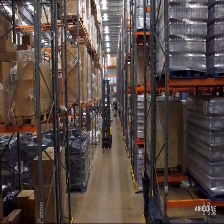


STEP: 2
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/clear_path/t2.jpg
Action: 3


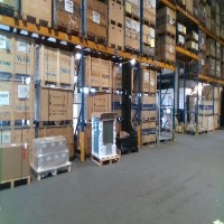


STEP: 3
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/clear_path/t3.jpg
Action: 0


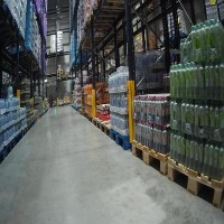


STEP: 4
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/clear_path/t4.jpg
Action: 0


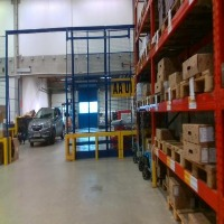


STEP: 5
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/clear_path/t5.jpg
Action: 3


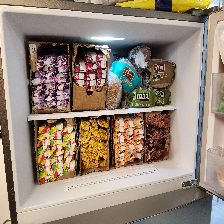


STEP: 6
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv1.jpg
Action: 3


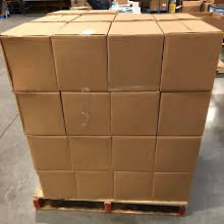


STEP: 7
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv2.jpeg
Action: 3


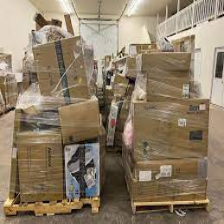


STEP: 8
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv3.jpeg
Action: 3


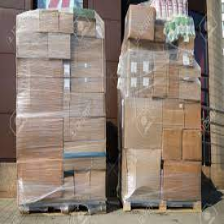


STEP: 9
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv4.jpeg
Action: 0


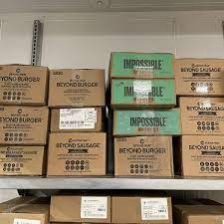


STEP: 10
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


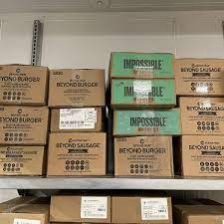


STEP: 11
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


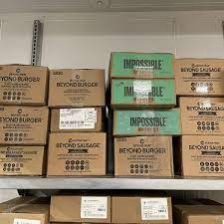


STEP: 12
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


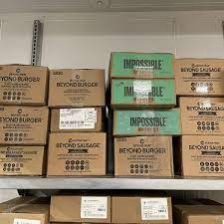


STEP: 13
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


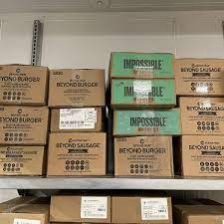


STEP: 14
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


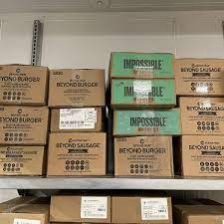


STEP: 15
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


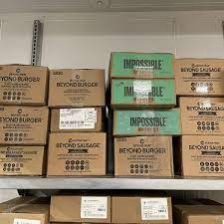


STEP: 16
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


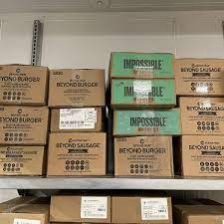


STEP: 17
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


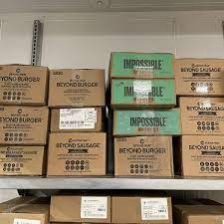


STEP: 18
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


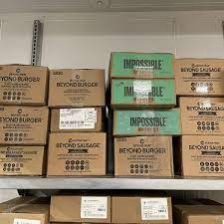


STEP: 19
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


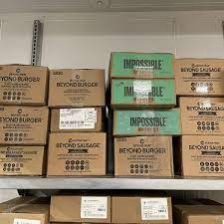


STEP: 20
Image: /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/obstacle/tv5.jpeg
Action: 3


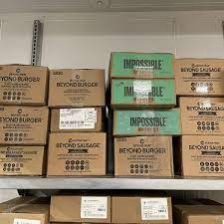

In [19]:
from google.colab.patches import cv2_imshow

#Test Model on images:
# Action 0: Forward
# Action 1: Left
# Action 2: Right
# Action 3: Stop

test_env = WarehouseEnv(mode="test")

obs, _ = test_env.reset()

for step in range(20):
    action, _ = model.predict(obs, deterministic=True)

    print("\nSTEP:", step+1)
    print("Image:", test_env.images[test_env.index])
    print("Action:", action)

    obs, reward, terminated, truncated, info = test_env.step(action)

    img = obs.transpose(1, 2, 0)
    cv2_imshow(img)
    # cv2.waitKey() and cv2.destroyAllWindows() are not needed with cv2_imshow in Colab

In [29]:
#Video Image robot predictions:
import os

search_dir = '/content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/videos'

if os.path.exists(search_dir) and os.path.isdir(search_dir):
    print(f"Contents of {search_dir}:")
    for item in os.listdir(search_dir):
        print(item)
else:
    print(f"Directory not found or is not a directory: {search_dir}")


Contents of /content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/videos:
video1.mp4
video2.mp4


In [30]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Define the video path
video_path = '/content/drive/MyDrive/Warehouse_robots_cnnRL/data/images/test/videos/video2.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    print(f"Processing video: {video_path}")
    while True:
        ret, frame = cap.read()

        # Break the loop if no more frames
        if not ret:
            print("End of video stream.")
            break

        # Preprocess the frame to match model input (224, 224, 3) HWC to (3, 224, 224) CHW
        resized_frame = cv2.resize(frame, (224, 224)) # Resizing to 224x224 HWC

        # Convert HWC to CHW and add batch dimension for model prediction
        model_input = np.transpose(resized_frame, (2, 0, 1)) # CHW
        model_input = np.expand_dims(model_input, axis=0) # Add batch dimension

        # Predict action (ensure model expects CHW input and single batch)
        action, _ = model.predict(model_input, deterministic=True)

        # Display the frame and predicted action
        # Convert back to HWC for cv2_imshow
        display_frame = resized_frame # cv2_imshow expects HWC

        # Add text for predicted action
        action_text = f"Action: {action[0]}" # action will be an array like [3]
        cv2.putText(display_frame, action_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        cv2_imshow(display_frame)

        # Wait for 100 milliseconds (adjust for desired video speed)
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

    # Release the video capture object
    cap.release()
    # cv2_imshow doesn't create windows that need destroying, so no cv2.destroyAllWindows() needed


Output hidden; open in https://colab.research.google.com to view.